# Modeling a DHN as a single pipe

![image](dhn_single_pipe.svg)

$\Delta T$ mean differences to ambient temperature $T_{env}$. 


\begin{equation*}
\dot{Q}_{prod} = c\dot{m} \hspace{3pt} (\Delta T_{prod,in} - \Delta T_{prod,r}) \\
\dot{Q}_{cons} = c\dot{m} \hspace{3pt} (\Delta T_{cons,r} - \Delta T_{cons,in}) \\
\dot{Q}_{loss,in} = c\dot{m} \hspace{3pt} (\Delta T_{cons,in} - \Delta T_{prod,in}) = c\dot{m} \Delta T_{prod,in} \hspace{3pt} exp \{-\frac{k\pi LD}{c\dot{m}}\}\\
\dot{Q}_{loss,r} = c\dot{m} \hspace{3pt} (\Delta T_{prod,r} - \Delta T_{cons,r}) = c\dot{m} \Delta T_{cons,r} \hspace{3pt} exp \{-\frac{k\pi LD}{c\dot{m}}\}\\
\dot{Q}_{prod} + \dot{Q}_{cons} + \dot{Q}_{loss,in} + \dot{Q}_{loss,r} = 0 \\
P_{el,pump} = \frac{1}{\eta}\frac{\Delta p }{\rho} \dot{m}
\end{equation*}

The following assumptions are made:
1. $\dot{Q}_{cons}$ is known
2. $\Delta T_{prod,in}$ is given by the Heizkurve
3. $\Delta T_{cons,in} - \Delta T_{cons,r} = \Delta T_{drop}$ is known

It follows from 1. that:

\begin{equation}
\dot{m} = \frac{\dot{Q}_{cons}}{c\Delta T_{drop}}.
\end{equation}

Together with 2., the mass flow is fixed. Next, the inlet temperature at the consumer is determined by:

\begin{equation}
\Delta T_{cons,in} = \Delta T_{prod,in} \hspace{3pt} exp \{-\frac{k\pi LD}{c\dot{m}}\}
\end{equation}

The return temperature at the consumer is given by 3. Again, the return temperature at the producer is reduced by losses on the return line:

\begin{equation}
\Delta T_{prod,r} = \Delta T_{cons,r} \hspace{3pt} exp \{-\frac{k\pi LD}{c\dot{m}}\}
\end{equation}

We are interested in $\dot{Q}_{prod}$. It can be determined by

\begin{equation}
\dot{Q}_{prod} = c\dot{m} (\Delta T_{prod,in} - \Delta T_{prod,r}).
\end{equation}

We insert above equations and finally get:

\begin{equation}
\dot{Q}_{prod} = \dot{Q}_{prod}(\dot{Q}_{cons}) = \dot{Q}_{cons} \frac{1}{\Delta T_{drop}}(\Delta T_{prod,in}(1- exp \{-2\frac{k\pi LD}{c\dot{m}}\}) + \Delta T_{drop} exp \{-\frac{k\pi LD}{c\dot{m}}\}) \\
P_{el,pump} = P_{el,pump}(\dot{Q}_{cons}) = 
\end{equation}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
   
def single_pipe(Q_cons, DT_drop, DT_prod_in, k, L, D, c):
    r"""
    
    
    """
    # hydraulic part
    # mass flow is determined by consumer mass flow
    m = Q_cons * 1 /(c*DT_drop)
    
    # pressure loss
    K = 3
    pressure_loss = K * m**2
    Dp_pump = 2 * pressure_loss
    P_pump = Dp_pump * m

    # heat losses in feedin and return pipe
    exponent = k * np.pi * L * D * 1/(c*m)
    DT_cons_in = DT_prod_in * np.exp(-1*exponent)
    DT_prod_r = (DT_cons_in - DT_drop) *  np.exp(-1*exponent)

    Q_prod = c * m * (DT_prod_in - DT_prod_r)
    Q_loss = Q_prod - Q_cons
    
    if DT_prod_r > 0:
        return {'Q_prod': Q_prod,
                'DT_cons_in': DT_cons_in,
                'DT_prod_r': DT_prod_r,
                'm': m,
                'pressure_loss': pressure_loss,
                'P_pump': P_pump,
                'Q_loss': Q_loss}
    else:
        return np.nan, np.nan, np.nan, np.nan, np.nan

/home/jann/Desktop/repos/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Rohrdurchmesser und Beschaffenheit, Druckverluste, Massenstrom und Pumpleistung



In [3]:
DT_drop = 10 # Kelvin
DT_prod_in = 80 # Kelvin, from Heizkurve
k = 0.001 # W/(m^2 * K) 
L = 500 #m 
D = 0.25 # m
c = 4182 # J/(kg*K) at 20°C
Q_cons = 50

# Verschiedene Wärmenachfragen
dic = {'Q_cons': [1000, 2000, 3000, 4000, 5000],
      'pressure_loss': [],
      'mass_flow': [],
      'Q_prod': [],
      'Q_loss': [],
      'P_pump': []}

for q in dic['Q_cons']:
    dic['pressure_loss'].append(single_pipe(q, DT_drop, DT_prod_in, k, L, D, c)['pressure_loss'])
    dic['P_pump'].append(single_pipe(q, DT_drop, DT_prod_in, k, L, D, c)['P_pump'])
    dic['mass_flow'].append(single_pipe(q, DT_drop, DT_prod_in, k, L, D, c)['m'])
    dic['Q_prod'].append(single_pipe(q, DT_drop, DT_prod_in, k, L, D, c)['Q_prod'])
    dic['Q_loss'].append(single_pipe(q, DT_drop, DT_prod_in, k, L, D, c)['Q_loss'])


df = pd.DataFrame(dic)
df = df.set_index('Q_cons')

df['loss_perc'] = df['Q_loss'] * 1/df['Q_prod']
df.head(2)

,pressure_loss,mass_flow,Q_prod,Q_loss,P_pump,loss_perc
Q_cons,,,,,,
1000,0.001715,0.023912,1058.666467,58.666467,0.000082,0.055415
2000,0.006861,0.047824,2058.785506,58.785506,0.000656,0.028553


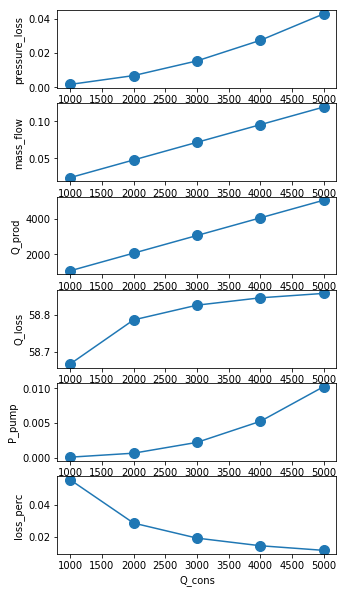

In [4]:
fig, axs = plt.subplots(len(df.columns), 1, figsize=(5,10))
for i, c in enumerate(df.columns):
    df[c].plot(ax=axs[i], marker='.', markersize=20)
    axs[i].set_xlabel('Q_cons')
    axs[i].set_ylabel(c)



Temperaturspreizung

Wärmeverluste

Kosten (Pumpkosten + Wärmekosten)

Bei versch. Außentemperaturen
Bei verschiedenen Temperaturniveaus